In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/test_rv

/content/drive/My Drive/test_rv


In [3]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=3712ddea0bf044b006a484e5b94778c55cfb30aee88fb2a8493d02bd28f33dd2
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [4]:
!pip install gluonts
!pip install lightning
!pip install ml_collections


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963

**Importing and preparation**

In [1]:

import numpy as np
import torch

seed = 42

torch.manual_seed(seed)
np.random.seed(seed)


**Preparing test data**

In [2]:
from DiffusionModel.dataprep import compute_technical_indicators , build_tech_dataset , create_lstm_dataset_seq2seq

import numpy as np
import torch
import pandas as pd
import core, test_utils
from torch.utils.data import TensorDataset, DataLoader

from DiffusionModel.core import TrainingNetwork


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


dataset = pd.read_csv("savings/industrial_monthly_data_vw.csv").dropna()



dataset = dataset.set_index(['Date','Industry'])



selected_features = [
    'Monthly_Return'
    ]

window = 12
time_horizon = 12
test_periods = 15
Test_time_horizon = time_horizon * test_periods
pred_len = 1

test_size = Test_time_horizon+window+pred_len - 1



num_layers = 2
num_cells= 20
cell_type = "LSTM"


input_size = 10
target_dim = 10
scale = 1
scale_c = 100

model = TrainingNetwork(input_size=input_size , num_cells= num_cells , num_layers= num_layers , cell_type=cell_type ,dropout_rate = 0.1,target_dim=target_dim,
           diff_steps = 500,
           prediction_length = pred_len,
           beta_min = 0.01,
           beta_end = 20,
           scale_c = 1,
           md_type = 'vpsde'
            )

model.to(device)
model.eval()
num_assets = model.target_dim
fea_dim = model.feature_dim

obs_dim = fea_dim + 2
act_dim = num_assets

test_scenario = core.ScenarioPool(num_assets, fea_dim, T=Test_time_horizon+1, size=1)



for i in range(1):
     data_set_end_date = 1
     test_dates = dataset.index.get_level_values('Date').unique()[-test_size-data_set_end_date:-data_set_end_date]
     test_data = dataset.loc[dataset.index.get_level_values('Date').isin(test_dates)]



     X_test,  y_test  = create_lstm_dataset_seq2seq(test_data,
                                   selected_features,
                                   target_col='Next_Monthly_Return',
                                   window_size=window,
                                   pred_len=pred_len)

     X_test = X_test*scale
     y_test = y_test*scale
# Convert to torch tensors

     X_test_t  = torch.from_numpy(X_test).float().to(device)    # (100, W, n_assets*num_features)
     y_test_t  = torch.from_numpy(y_test).float().to(device)    # (100, W, n_assets)
     test_ds  = TensorDataset(X_test_t,  y_test_t)
     test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, drop_last=False)

#One forward pass to initialize the model
     if i == 0:
       with torch.no_grad():
        rnn_output, _ = model.rnn(X_test_t[-1:,-1:,:])
        cond = rnn_output[-1:,-1:,:] # Forward pass to initialize the model
        tstep = torch.rand((1,)).to(device)
        _ = model.model(X_test_t[-1:,-pred_len:,:], tstep, cond)
     save_path_diffusion = f'savings/models/diffusion_model_industrial_exp_dataset{data_set_end_date}_final.pth'
     if torch.cuda.is_available():
           model.load_state_dict(torch.load(save_path_diffusion))
     else:
           model.load_state_dict(torch.load(save_path_diffusion, map_location=torch.device('cpu')))

     s = np.ones((Test_time_horizon+1,num_assets))
     h = np.zeros((Test_time_horizon+1,fea_dim))



     for t in range(Test_time_horizon):
        s[t+1,:] = s[t,:]*(1+X_test[t+1,-1,:]/scale)
        context = X_test_t[t, :, :]
        with torch.no_grad():
            rnn_output, _  = model.rnn(context)
            h[t, :] = rnn_output[-1,:].cpu().numpy()*scale_c
     test_scenario.store(s,h)


/Users/fengyyuan/anaconda3/envs/diffusion_mv/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


**Prepare the Baseline**

In [24]:
from re import A
from DiffusionModel.config import get_ddpm_config
import copy
import yfinance as yf



config = get_ddpm_config()
config['sampling']['corrector'] = 'langevin'
config['sampling']['predictor'] = 'reverse_diffusion'



test_frequency = 12
risk_aversion = 3
num_test_episodes = 1
#Bulding the test baselines
action_ew = []
action_genmkw = []
action_histmkw = []
action_ew_array = []
action_genmkw_array = []
action_histmkw_array = []








for i in range(1):
  data_set_end_date = 1
  prediction_returns = np.load(f'savings/variables/genmkw_returns_industrial_exp_dataset{data_set_end_date}_final.npy')
  for t in range(Test_time_horizon):
    action_ew.append(1/num_assets)  # Equal weights for each asset


    # Markowitz based on generated data

    mean_gen = np.mean(prediction_returns[t+1]/scale, axis=0)
    cov_gen = np.cov(prediction_returns[t+1]/scale, rowvar=False)
    action_genmkw.append(test_utils.solve_markowitz(mean_gen, cov_gen, risk_aversion, num_assets))

    # Markowitz based on historical data
    test_dates = dataset.index.get_level_values('Date').unique()[-test_size-data_set_end_date:-data_set_end_date]
    test_data = dataset.loc[dataset.index.get_level_values('Date').isin(test_dates)]
    date_t = test_data.index.get_level_values('Date')[t + window - 1]

    all_dates = dataset.index.get_level_values('Date').unique()
    idx = np.where(all_dates == date_t)[0][0]
    start_idx = max(0, idx - 59)
    selected_dates = all_dates[start_idx:idx+1]


    historical = dataset.loc[dataset.index.get_level_values('Date').isin(selected_dates), 'Monthly_Return']
    historical = historical.unstack(level='Industry')
    mean_hist = historical.values.mean(axis=0)
    cov_hist = np.cov(historical, rowvar=False)
    action_histmkw.append(test_utils.solve_markowitz(mean_hist, cov_hist, risk_aversion, num_assets))

  action_ew_array.append(copy.copy(action_ew))
  action_genmkw_array.append(copy.copy(action_genmkw))
  action_histmkw_array.append(copy.copy(action_histmkw))



#Equal Weights (EW)
ew_return_list = test_utils.test_agent_baseline(test_scenario, Test_time_horizon+1, num_test_episodes,
                                                                                                   num_assets, risk_aversion, test_frequency, action_ew_array)

#Markowitz based on generated data (GenMarkowitz)
genmkw_return_list = test_utils.test_agent_baseline(test_scenario, Test_time_horizon+1, num_test_episodes,
                                                                                                   num_assets, risk_aversion, test_frequency, action_genmkw_array)

#Markowitz based on history (HistMarkowitz)
histmkw_return_list = test_utils.test_agent_baseline(test_scenario, Test_time_horizon+1, num_test_episodes,
                                                                                                   num_assets, risk_aversion, test_frequency, action_histmkw_array)

#SP500 index
data = yf.download('^GSPC',
                   start='2010-03-31',
                   end='2025-03-31',
                   progress=False)

print("DataFrame col:", data.columns.tolist())

sp500_monthly = data['Close'].resample('M').last()


sp500_return_list = sp500_monthly.pct_change().dropna()

DataFrame col: [('Close', '^GSPC'), ('High', '^GSPC'), ('Low', '^GSPC'), ('Open', '^GSPC'), ('Volume', '^GSPC')]


/var/folders/xj/1q5w16gx54q_3c839vy4fs_m0000gn/T/ipykernel_28994/314852594.py:88: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sp500_monthly = data['Close'].resample('M').last()


**Test results for the final output**

In [25]:
#num_test_episodes = 200

#test_generator_final = core.ScenarioGenerator(num_assets, fea_dim, Test_time_horizon, num_test_episodes, 'simulate', simulate_mean, simulate_cov, None, mode = 'testing')
#test_scenario_final = test_generator_final.get_data()

ac_final = core.MLPActorCritic_TD3(obs_dim, act_dim)
ac_final.to(device)
ac_array = []
ac_array_in_episode = []
retrain_frequency = 90

for i in range(1):
  data_set_end_date = 1
  for j in range(Test_time_horizon//retrain_frequency):
     _ = core.load_td3_checkpoint(
        ac_final.pi, ac_final.q1, filename = f'savings/models/td3_industrial_exp_ol_dataset{data_set_end_date}_retrain{j+1}_final.pth')

     #_ = core.load_td3_checkpoint(
     #   ac_final.pi, ac_final.q1, filename = f'savings/models/td3_industrial_exp_dataset{data_set_end_date}.pth')
     ac_array_in_episode.append(copy.deepcopy(ac_final))
  ac_array.append(ac_array_in_episode)


#


td3_return_list, portfolio_array = test_utils.test_agent_td3(test_scenario, Test_time_horizon+1, num_test_episodes,
                                                              num_assets, ac_array, risk_aversion,
                                                              test_frequency, retrain_frequency,scale_t=10,multiplier_update_steps=200,m_lr=5e-2)







Checkpoint loaded from savings/models/td3_industrial_exp_ol_dataset1_retrain1_final.pth (episode 100)
Checkpoint loaded from savings/models/td3_industrial_exp_ol_dataset1_retrain2_final.pth (episode 100)
Time: 0 Optimal dual multiplier (hedging target): 0.35702383518218994
Time: 12 Optimal dual multiplier (hedging target): 0.8625248670578003
Time: 24 Optimal dual multiplier (hedging target): 0.8423553109169006
Time: 36 Optimal dual multiplier (hedging target): 0.9653613567352295
Time: 48 Optimal dual multiplier (hedging target): 1.1238054037094116
Time: 60 Optimal dual multiplier (hedging target): 1.4342323541641235
Time: 72 Optimal dual multiplier (hedging target): 1.247790813446045
Time: 84 Optimal dual multiplier (hedging target): 1.9255732297897339
Time: 96 Optimal dual multiplier (hedging target): 4.1144700050354
Time: 108 Optimal dual multiplier (hedging target): 3.8852460384368896
Time: 120 Optimal dual multiplier (hedging target): 3.4990806579589844
Time: 132 Optimal dual multi

**Tables**

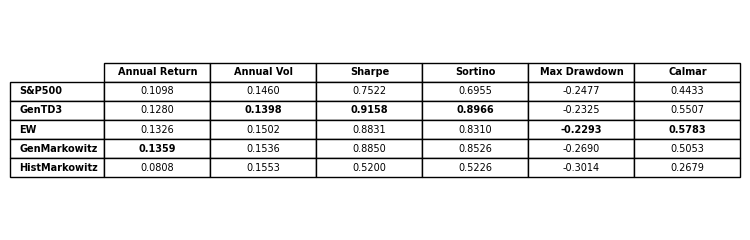

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

return_data = {
        'S&P500': sp500_return_list,
        'GenTD3': td3_return_list[:,0],
        'EW' : ew_return_list[:,0],
        'GenMarkowitz' : genmkw_return_list[:,0],
        'HistMarkowitz' : histmkw_return_list[:,0]
    }

metrics_df = pd.DataFrame({k: test_utils.compute_metrics(v, test_frequency, Test_time_horizon/test_frequency) for k, v in return_data.items()}).T.round(4)

# === 3. Identify best portfolios per metric ===
best_portfolio = {}
for col in metrics_df.columns:
    if col == "Annual Vol":
        best_portfolio[col] = metrics_df[col].idxmin()
    else:
        best_portfolio[col] = metrics_df[col].idxmax()

# === 4. Create a matplotlib table with bolded best values ===
fig, ax = plt.subplots(figsize=(8, 2.5))
ax.axis('off')

# Prepare table data
table_data = []
for idx, row in metrics_df.iterrows():
    row_vals = []
    for col in metrics_df.columns:
        val = f"{row[col]:.4f}"
        # Mark best values
        if idx == best_portfolio[col]:
            val = f"\\textbf{{{val}}}"
        row_vals.append(val)
    table_data.append(row_vals)

# Create table
table = ax.table(cellText=table_data,
                 rowLabels=metrics_df.index,
                 colLabels=metrics_df.columns,
                 cellLoc='center',
                 loc='center')

# Adjust font for bold entries
for (row, col), cell in table.get_celld().items():
    if row == 0:
        # Header row bold
        cell.get_text().set_fontweight('bold')
    elif col == -1:
        # Row labels bold
        cell.get_text().set_fontweight('bold')
    else:
        # Check for LaTeX bold markers
        text = cell.get_text().get_text()
        if text.startswith("\\textbf"):
            # Extract value without LaTeX syntax and set bold
            value = text.replace("\\textbf{", "").replace("}", "")
            cell.get_text().set_text(value)
            cell.get_text().set_fontweight('bold')

plt.tight_layout()
plt.show()

**Figures**

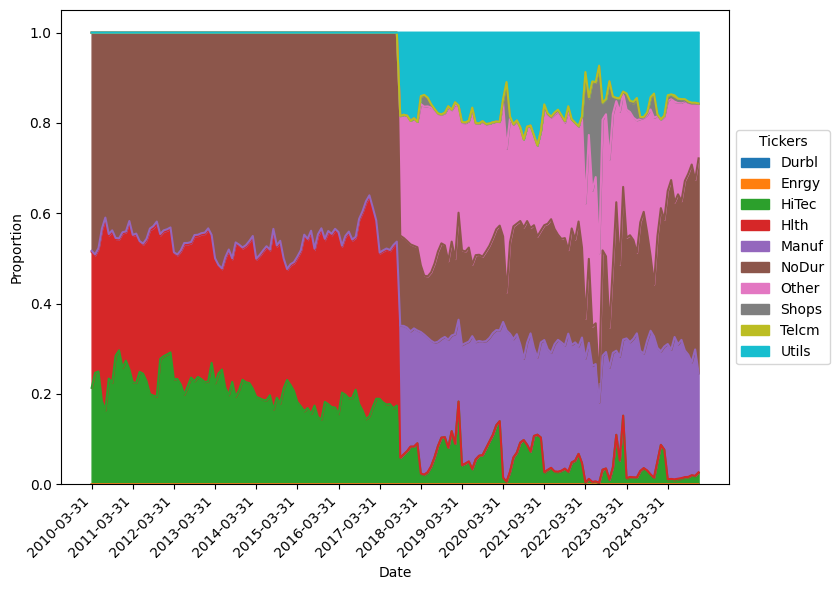

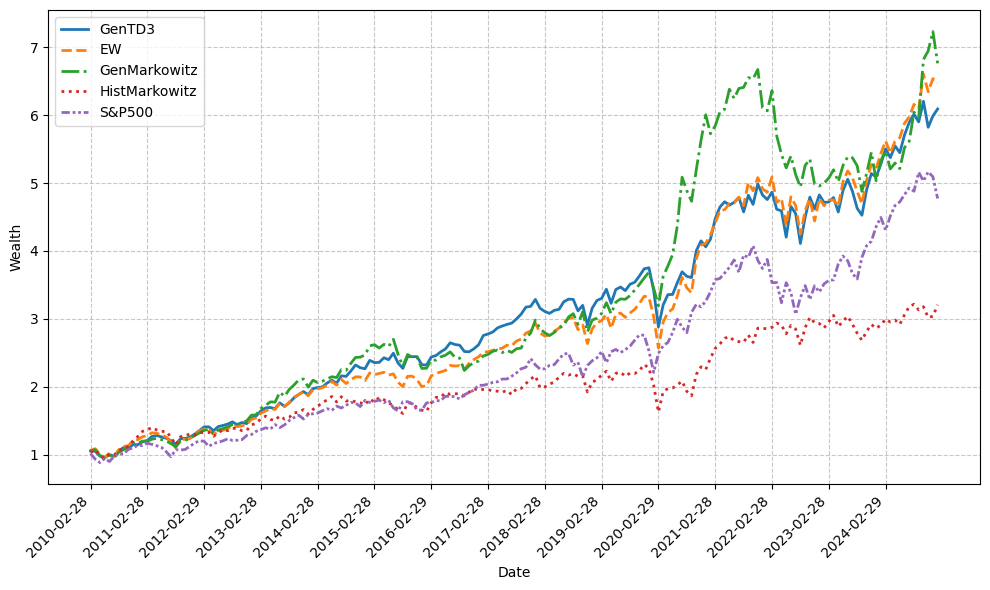

In [27]:
test_utils.plot_portfolio(portfolio_array[0, :Test_time_horizon-2],Test_time_horizon-2,num_assets,dataset,test_dates)

algo_list = ['GenTD3', 'EW', 'GenMarkowitz', 'HistMarkowitz', 'S&P500']

wealth_data = {
        'S&P500': np.cumprod(1+sp500_return_list.values).reshape(-1, 1),
        'GenTD3': np.cumprod(1+td3_return_list, axis = 0),
        'EW' : np.cumprod(1+ew_return_list, axis = 0),
        'GenMarkowitz' : np.cumprod(1+genmkw_return_list, axis = 0),
        'HistMarkowitz' : np.cumprod(1+histmkw_return_list, axis = 0)
    }
test_utils.plot_wealth_trajectory(algo_list,wealth_data, test_dates)